# 导入模块及定义

## 导入模块

In [1]:
import os
import argparse
import math
import random
import tqdm
import numpy as np
import pandas as pd
from sklearn import preprocessing

from script import dataloader, utility, earlystopping
from model import models

import matplotlib.pyplot as plt
import seaborn as sns
import transbigdata as tbd

import networkx as nx

from typing import List

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils

from torch_geometric.data import Data

Obtaining city id: 北京success
Get bus data: 1号线
地铁1号线八通线(环球度假区-古城) success
地铁1号线八通线(古城-环球度假区) success
地铁1号线支线(八角游乐园-青龙湖东) success
地铁1号线支线(青龙湖东-八角游乐园) success
Get bus data: 2号线
地铁2号线外环(西直门-西直门) success
地铁2号线内环(积水潭-积水潭) success
地铁6号线二期(潞城-东小营南) success
地铁6号线二期(东小营南-潞城) success
Get bus data: 5号线
地铁5号线(宋家庄-天通苑北) success
地铁5号线(天通苑北-宋家庄) success
Get bus data: 6号线
地铁6号线(金安桥-潞城) success
地铁6号线(潞城-金安桥) success
Get bus data: 7号线
地铁7号线(北京西站-环球度假区) success
地铁7号线(环球度假区-北京西站) success
Get bus data: 8号线
地铁8号线(朱辛庄-瀛海) success
地铁8号线(瀛海-朱辛庄) success
Get bus data: 9&房山线
地铁9号线(国家图书馆-郭公庄) success
地铁9号线(郭公庄-国家图书馆) success
Get bus data: 房山线
地铁房山线(东管头南-阎村东) success
地铁房山线(阎村东-东管头南) success
大兴机场大巴房山线(房山区交通局-大兴机场) success
大兴机场大巴房山线(大兴机场-房山区交通局) success
Get bus data: 10号线
地铁10号线外环(车道沟-车道沟) success
地铁10号线内环(巴沟-巴沟) success
Get bus data: 13号线
地铁13号线(东直门-西直门) success
地铁13号线(西直门-东直门) success
地铁13A号线(天通苑东-车公庄) success
地铁13A号线(车公庄-天通苑东) success
Get bus data: 15号线
地铁15号线(清华东路西口-俸伯) success
地铁15号线(俸伯-清华东路西口) success
Get bus 

/home/africar/CTS-transmit/.venv/lib/python3.12/site-packages/transbigdata/crawler.py:284: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  data['geometry'] = lines
/home/africar/CTS-transmit/script/utility.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat([output_df, new_row], ignore_index=True)


tmp_rem_df.__len__ is  6480


/home/africar/CTS-transmit/script/utility.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat([output_df, new_row], ignore_index=True)


tmp_rem_df.__len__ is  6480


/home/africar/CTS-transmit/script/utility.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat([output_df, new_row], ignore_index=True)


tmp_rem_df.__len__ is  6480


/home/africar/CTS-transmit/script/utility.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat([output_df, new_row], ignore_index=True)


tmp_rem_df.__len__ is  6480


/home/africar/CTS-transmit/script/utility.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat([output_df, new_row], ignore_index=True)


tmp_rem_df.__len__ is  6480


/home/africar/CTS-transmit/script/utility.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat([output_df, new_row], ignore_index=True)


tmp_rem_df.__len__ is  6480


/home/africar/CTS-transmit/script/utility.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat([output_df, new_row], ignore_index=True)


tmp_rem_df.__len__ is  6480
output_df.__len__ is  106848


## 声明和定义模型各层

In [ ]:
import torch.nn.functional as F
import torch.nn.init as init

from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
class TemporalConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(TemporalConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=(kernel_size[0] // 2, 0))

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  # (batch, N, T, F) -> (batch, F, T, N)
        x = self.conv(x)
        x = x.permute(0, 2, 3, 1)  # (batch, F, T, N) -> (batch, N, T, F)
        return x

class SpatialConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SpatialConvLayer, self).__init__()
        self.gcn = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x: (batch, N, T, F)
        # edge_index: (2, E)
        batch_size, num_nodes, time_steps, num_features = x.shape
        x = x.permute(0, 2, 1, 3)  # (batch, N, T, F) -> (batch, T, N, F)
        x = x.reshape(-1, num_nodes, num_features)  # (batch * T, N, F)
        
        # Flatten edge_index
        edge_index = edge_index.repeat(time_steps * batch_size, 1)  # Repeat edge_index for each time step and batch
        edge_index = edge_index.view(2, -1)  # (2, E * batch_size * time_steps)
        
        x = x.reshape(-1, num_features)  # (batch * T * N, F)
        x = self.gcn(x, edge_index)
        x = x.view(batch_size, time_steps, num_nodes, -1)  # (batch, T, N, F)
        x = x.permute(0, 2, 1, 3)  # (batch, T, N, F) -> (batch, N, T, F)
        return x
    
class GCNConvLayer(MessagePassing):
    """GCNConv Layer, copied from pyG official website"""
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out

## 申明和定义模型

In [ ]:
import torch.nn.functional as F
from torch.nn import Module
import torch.nn as nn
import torch
from model import layers

class GCN(Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = layers.GCNConvLayer(num_features, 24)
        self.conv2 = layers.GCNConvLayer(24, 16)
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # node_mask = data.node_mask

        # if node_mask is not None:
        #     x = x * node_mask.unsqueeze(-1)

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        x = F.relu(x)
        return x#F.log_softmax(x, dim=1)

class STGCN(nn.Module):
    def __init__(self, num_nodes, in_channels, time_steps, temporal_channels, spatial_channels, kernel_size,out_channels):
        super(STGCN, self).__init__()
        self.num_nodes = num_nodes
        self.time_steps = time_steps
        self.temporal1 = TemporalConvLayer(in_channels, temporal_channels, kernel_size)
        self.spatial = SpatialConvLayer(temporal_channels, spatial_channels)
        self.temporal2 = TemporalConvLayer(spatial_channels, in_channels, kernel_size)
        self.fc = torch.nn.Linear(num_nodes * in_channels * time_steps, num_nodes * out_channels * time_steps)

    def forward(self, x, edge_index):
        x = self.temporal1(x)
        x = self.spatial(x, edge_index)
        x = self.temporal2(x)
        x = x.reshape(x.shape[0], -1)  # Flatten
        x = self.fc(x)
        x = x.reshape(x.shape[0], self.num_nodes, self.time_steps, -1)  # Reshape back to (batch, N, T, F)
        return x

# 数据获取及预处理

## 抓取实际站点数据，筛选处理之，并生成邻接矩阵

In [ ]:
# station数据预处理函数
def station2staion_no_line(station):
    station_no_line = pd.DataFrame()
    for i in range(len(station['站点名'].unique())):
        spec_time_place_station = station[station['站点名'] == station['站点名'].unique()[i]]
        # spec_time_place_station = spec_time_place_station[['开始时间','线路名','站点名','进站量','出站量']]
        spec_time_place_station = spec_time_place_station.fillna(0)
        spec_time_place_station = spec_time_place_station.groupby(['日期','开始时间','结束时间']).agg({
            '站点名': 'first',  # 假设每个时间段内站点名是相同的，取第一个即可
            '进站量': 'sum',
            '出站量': 'sum'
        })
        spec_time_place_station = spec_time_place_station.reset_index()
        station_no_line = pd.concat([station_no_line, spec_time_place_station]).reset_index(drop=True)
    return station_no_line


# prepare data
line,stop = tbd.getbusdata('北京',['1号线', '2号线', '5号线', '6号线', '7号线', '8号线', '9&房山线','房山线', '10号线',
       '13号线', '15号线', '昌平线', '首都机场线'])
line = line[line['line']!='大兴机场大巴首都机场线'].reset_index(drop=True)
stop = stop[stop['line']!='大兴机场大巴首都机场线'].reset_index(drop=True)
line = line[line['line']!='首都机场大巴昌平线'].reset_index(drop=True)
stop = stop[stop['line']!='首都机场大巴昌平线'].reset_index(drop=True)
stop.loc[stop['stationnames'] == '清河站', 'stationnames'] = '清河'

line_data = {'线路名': [], '站点名': [], '顺序': []}
for i in range(len(stop)):
    线路名 = line_data['线路名']
    线路名.append(stop.loc[i, 'line'])
    站点名 = line_data['站点名']
    站点名.append(stop.loc[i, 'stationnames'])
    顺序 = line_data['顺序']
    顺序.append(stop.loc[i, 'id'])
    line_data.update({'线路名':线路名, '站点名':站点名, '顺序':顺序})
# 示例数据
# line_data = {
#     '线路名': ['1号线', '1号线', '1号线', '2号线', '2号线'],
#     '站点名': ['站点A', '站点B', '站点C', '站点B', '站点D'],
#     '顺序': [1, 2, 3, 1, 2]
# }


stop_data = {'站点名':list(stop['stationnames'].unique())}
# 示例数据
# stop_data = {
#     '站点名': ['站点A', '站点B', '站点C', '站点D'],
#     '其他信息': ['infoA', 'infoB', 'infoC', 'infoD']
# }

line_for_adj = pd.DataFrame(line_data)
stop_for_adj = pd.DataFrame(stop_data)

# 构建地铁网络图
G = nx.Graph()

# 添加节点
for station_for_adj in stop_for_adj['站点名']:
    G.add_node(station_for_adj)

# 添加边（根据站点顺序）
for line_name, group in line_for_adj.groupby('线路名'):
    sorted_stations = group.sort_values('顺序')['站点名'].tolist()
    for i in range(len(sorted_stations) - 1):
        G.add_edge(sorted_stations[i], sorted_stations[i + 1])

# 提取邻接矩阵
adj_matrix = nx.adjacency_matrix(G).todense()

## 读取csv文件数据

In [ ]:
# 读取csv
path = 'CTS-2024-dataset/'
station_csv_file = ['station_20230519.csv',
                    'station_20230520.csv',
                    'station_20230521.csv',
                    'station_20230522.csv',
                    'station_20230523.csv',
                    'station_20230524.csv',
                    'station_20230525.csv',]
station_input_csv_select = range(len(station_csv_file))
station_csv_sel_list = [path + station_csv_file[i] for i in station_input_csv_select]
# stationList = utility.cstRawCsvData([path + station_csv_file[i] for i in station_input_csv_select])
station = utility.get_station_for_adj(stop_for_adj, station_csv_sel_list)
station = station2staion_no_line(station) # 合并分布在不同线路上的同一站点数据

## 数据预处理

In [2]:
# 数据预加载
from datetime import datetime

sta_info_for_adj = pd.DataFrame(columns=['station_name', 'abs_date', 'time_point', 'day_of_week', 'is_event', 'in_flow', 'out_flow'])
for i in range(len(station)):
    station_name = station.loc[i, '站点名']
    precise_time = datetime.strptime(station.loc[i, '开始时间'], '%Y/%m/%d %H:%M:%S')

    time_diff = precise_time - datetime.strptime('2023/5/19 00:00:00', '%Y/%m/%d %H:%M:%S')
    abs_date = time_diff.days + 1 # 从1开始编号，五月19是第一天

    time_point = (precise_time.hour * 60 + precise_time.minute) / 30

    day_of_week = precise_time.weekday() # Monday == 0 ... Sunday == 6

    event_condition = ((precise_time.day == 26 or precise_time.day == 27) and precise_time.month == 5) or ((precise_time.day == 25) and precise_time.month == 8)
    is_event = 1.0 if event_condition else 0.0

    in_flow = float(station.loc[i, '进站量'])
    out_flow = float(station.loc[i, '出站量'])

    sta_info_for_adj.loc[i] = [station_name, abs_date, time_point, day_of_week, is_event, in_flow, out_flow]


## 设置站点掩码

In [4]:
def get_station_mask(stop_for_adj: pd.DataFrame, csv_list: list[str]) -> torch.tensor:
    output_mask = torch.ones(len(stop_for_adj)).tolist()
    categories_list = list(stop_for_adj['站点名'])
    rem_stop_list = utility.get_rem_sta_list(stop_for_adj, csv_list)
    for stop_i in range(len(categories_list)):
        if categories_list[stop_i] in rem_stop_list:
            output_mask[stop_i] = False

    for i in range(len(output_mask)):
        if output_mask[i]:
            output_mask[i] = True

    return torch.tensor(output_mask)

station_mask = get_station_mask(stop_for_adj, station_csv_sel_list)
station_mask

the length of remain_staion_list is  135


tensor([ True, False, False, False, False,  True, False,  True,  True, False,
        False,  True, False,  True,  True, False,  True, False,  True,  True,
         True,  True, False,  True,  True,  True, False, False,  True,  True,
         True,  True,  True, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True, False, False, False,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True, False,
         True, False, False,  True,  True, False, False, False,  True, False,
         True,  True,  True,  True, False,  True,  True,  True,  True, False,
         True,  True, False, False, False, False,  True, False, False, False,
        False,  True, False, False,  True,  True,  True, False, False,  True,
         True, False,  True,  True, False, False, False,  True,  True, False,
         True,  True,  True, False,  True,  True, False,  True,  True,  True,
         True,  True, False, False,  True, False, False, False, 

## 预处理数据放入input_data中

In [5]:
def norm_min_max(input_array: np.array, min_array: np.array, max_array: np.array) -> np.array:
    return (input_array - min_array) / (max_array - min_array)

def abnorm_min_max(input_array: np.array, min_array: np.array, max_array: np.array) -> np.array:
    return input_array * (max_array - min_array) + min_array

from sklearn.preprocessing import StandardScaler

categories_list = list(stop_for_adj['站点名'])
ori_x = []
ori_y = []
# scaler = StandardScaler()
norm_x = []
norm_y = []
for i in sta_info_for_adj.groupby(["abs_date","time_point"]):
    temp = i[1]
    temp['station_name'] = pd.Categorical(temp['station_name'], categories=categories_list, ordered=True)
    temp = temp.sort_values(by=['station_name']).reset_index(drop=True)#特定日期特定时间的所有站点已知数据
    features = temp[['abs_date','time_point','day_of_week','is_event']].values
    labels = temp[['in_flow','out_flow']].values
    ori_x.append(features)
    ori_y.append(labels)
    # features = scaler.fit_transform(features)
    # labels = scaler.fit_transform(labels)
    # norm_x.append(features)
    # norm_y.append(labels)

total_x = np.vstack(ori_x)
total_y = np.vstack(ori_y)

min_x, max_x = total_x.min(axis=0), total_x.max(axis=0)
for i in range(len(max_x)):
    if max_x[i] == min_x[i]:
        max_x[i] = 1.0
min_y, max_y = total_y.min(axis=0), total_y.max(axis=0)

for i in range(len(ori_x)):
    tmp_feature = norm_min_max(ori_x[i], min_x, max_x)
    tmp_labels = norm_min_max(ori_y[i], min_y, max_y)
    norm_x.append(tmp_feature)
    norm_y.append(tmp_labels)
norm_x = np.array(norm_x)
norm_y = np.array(norm_y)



# 准备模型输入与loss标杆
# 找到所有非零元素的索引
adj_matrix = np.array(adj_matrix)
row, col = np.nonzero(adj_matrix)

# 将这些索引转换为 PyTorch 张量
edge_index = torch.tensor(np.array([row, col]), dtype=torch.long)
data_input: List[Data] = [Data(x=torch.tensor(norm_x[epoch], dtype=torch.float),
                               edge_index=edge_index,
                               y=torch.tensor(norm_y[epoch], dtype=torch.float),
                               node_mask=station_mask)
                          for epoch in range(len(norm_x))]

In [42]:
total_x[:, 3].sum()

np.float64(0.0)

In [15]:
qq = []
for i in sta_info_for_adj.groupby(["abs_date","time_point"]):
    qq.append(i)

## 转换格式以适配STGCN

In [6]:
# 将datainput中的数据转换为STGCN能用的格式

traning_data = data_input[:-48]
time_nodes_features = []
for i in range(len(traning_data)):
    time_nodes_features.append(traning_data[i].x)
time_nodes_features = torch.stack(time_nodes_features)
nodes_time_features = time_nodes_features.permute(1, 0, 2)
STGCNX = nodes_time_features.unsqueeze(0)
time_nodes_labels = []
for i in range(len(traning_data)):
    time_nodes_labels.append(traning_data[i].y[:,0])
time_nodes_labels = torch.stack(time_nodes_labels)
time_nodes_labels = time_nodes_labels.unsqueeze(-1)
nodes_time_labels = time_nodes_labels.permute(1, 0, 2)
STGCNY = nodes_time_labels.unsqueeze(0)

In [7]:
STGCNX.shape

torch.Size([1, 285, 288, 4])

In [8]:
STGCNY = STGCNY.view(1, 285, 6, 48, 1).permute(2, 1, 3, 4, 0).squeeze(-1)
STGCNX = STGCNX.view(1, 285, 6, 48, 4).permute(2, 1, 3, 4, 0).squeeze(-1)
STGCNX.shape

torch.Size([6, 285, 48, 4])

# 训练及预测

## 训练STGCN

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import torch.optim as optim
from torch_geometric.nn import GCNConv
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

# 假设你已经有了输入数据和标签数据
# 输入数据形状: (batch_size, N, T, F)
# 标签数据形状: (batch_size, N, T, F)
# edge_index: 图的边信息，形状为 (2, E)
from tqdm import tqdm
from model import models
# 模拟数据
batch_size = STGCNY.shape[0]
num_nodes = STGCNY.shape[1]
time_steps = STGCNY.shape[2]
num_features = STGCNX.shape[3]

x = STGCNX
y = STGCNY
edge_index = data_input[0].edge_index

# 定义模型、损失函数和优化器
model = STGCN(num_nodes, num_features,time_steps, 16, 32, (3, 1),1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练循环
num_epochs = 50
for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    output = model(x, edge_index)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

NameError: name 'STGCNY' is not defined

## 训练GCN（效果不佳）

In [80]:
# prepare model parameters
num_features = 4
num_classes = 2
model = models.GCN(num_features, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()


In [68]:
model

GCN(
  (conv1): GCNConvLayer()
  (conv2): GCNConvLayer()
)

In [208]:
# start training
import random
duptimes = 50 # 每个数据输入进模型训练的次数
total_input_sz = len(data_input)
# random.shuffle(data_input)
test_set_sz = 48 # 预测集大小
train_set_sz = total_input_sz - test_set_sz
model.train()
for dup_i in range(duptimes):
    optimizer.zero_grad()  # 清除梯度
    loss1,loss2=0.0,0.0
    for epoch in range(train_set_sz):
        out_y = model(data_input[epoch])  # 前向传播
        out_y1_for_loss = out_y[:, 0][station_mask]
        out_y2_for_loss = out_y[:, 1][station_mask]
        true_y1_for_loss = data_input[epoch].y[:, 0][station_mask]
        true_y2_for_loss = data_input[epoch].y[:, 1][station_mask]
        loss1 += criterion(out_y1_for_loss, true_y1_for_loss)  # 计算损失
        loss2 += criterion(out_y2_for_loss, true_y2_for_loss)
    loss = loss1+loss2  # 加权求和
    if dup_i % (duptimes / 20) == 0:
        print('dup_i=', dup_i, '\t\tloss=', loss1.item(),loss2.item())
    loss.backward()  # 反向传播
    optimizer.step()  # 更新参数



dup_i= 0 		loss= 1.0487738847732544 0.8866744637489319
dup_i= 5 		loss= 1.045677661895752 0.8850721716880798
dup_i= 10 		loss= 1.0426113605499268 0.8833793997764587
dup_i= 15 		loss= 1.039470911026001 0.881721556186676
dup_i= 20 		loss= 1.0361483097076416 0.8800247311592102
dup_i= 25 		loss= 1.0327740907669067 0.8782592415809631
dup_i= 30 		loss= 1.0288740396499634 0.8764190077781677
dup_i= 35 		loss= 1.0245531797409058 0.8745103478431702
dup_i= 40 		loss= 1.0207010507583618 0.8726089596748352
dup_i= 45 		loss= 1.0170156955718994 0.870704710483551


In [200]:
data_input[epoch].y[:, 1]

tensor([6.9284e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2788e-02,
        0.0000e+00, 3.0757e-02, 3.2376e-03, 0.0000e+00, 0.0000e+00, 1.9425e-02,
        0.0000e+00, 2.8005e-02, 2.1611e-02, 0.0000e+00, 1.1291e-01, 0.0000e+00,
        3.6018e-02, 3.5775e-02, 9.6722e-02, 3.5880e-01, 0.0000e+00, 6.9284e-02,
        2.1530e-02, 2.1611e-02, 0.0000e+00, 0.0000e+00, 2.2258e-02, 1.8778e-02,
        4.8644e-02, 2.8652e-02, 2.3229e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.2958e-01, 3.0676e-02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.2465e-02, 1.1501e-01, 7.2926e-02, 1.3954e-01, 0.0000e+00,
        2.6224e-02, 8.9599e-02, 1.5977e-01, 1.8373e-02, 2.4363e-02, 0.0000e+00,
        1.3274e-02, 0.0000e+00, 0.0000e+00, 1.8778e-02, 1.5217e-02, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.6710e-02, 0.0000e+00, 3.7232e-02, 2.3391e-02,
        1.6997e-02, 2.1449e-02, 0.0000e+

## 预测

In [209]:
# make prediction
model.eval()
predict_data: List[Data] = data_input[:train_set_sz]

predict_in_flow = []
predict_out_flow = []
for piece in predict_data:
    pre_out = model(piece)
    pre_out = abnorm_min_max(pre_out.detach(), min_y, max_y)
    predict_in_flow.append(pre_out[:, 0][station_mask])
    predict_out_flow.append(pre_out[:, 1][station_mask])

/tmp/ipykernel_2772/949442471.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return input_array * (max_array - min_array) + min_array


In [191]:
piece.x

tensor([[0.1667, 0.3830, 0.8333, 0.0000],
        [0.1667, 0.3830, 0.8333, 0.0000],
        [0.1667, 0.3830, 0.8333, 0.0000],
        ...,
        [0.1667, 0.3830, 0.8333, 0.0000],
        [0.1667, 0.3830, 0.8333, 0.0000],
        [0.1667, 0.3830, 0.8333, 0.0000]])

## 验证效果

In [214]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 将预测值和真实值转换为 numpy 数组以便使用 sklearn 库计算评估指标
true_in_flow = np.array([data.y[:, 0][station_mask].detach().numpy() for data in predict_data])
true_out_flow = np.array([data.y[:, 1][station_mask].detach().numpy() for data in predict_data])
predicted_in_flow = np.array([out.detach().numpy() for out in predict_in_flow])
predicted_out_flow = np.array([out.detach().numpy() for out in predict_out_flow])

# 计算 MAE 和 RMSE
true_in_flow = abnorm_min_max(true_in_flow,min_y[0],max_y[0])
true_out_flow = abnorm_min_max(true_out_flow,min_y[1],max_y[1])
mae_in = mean_absolute_error(true_in_flow, predicted_in_flow)
rmse_in = np.sqrt(mean_squared_error(true_in_flow, predicted_in_flow))

mae_out = mean_absolute_error(true_out_flow, predicted_out_flow)
rmse_out = np.sqrt(mean_squared_error(true_out_flow, predicted_out_flow))

print(f"MAE for In-Flow: {mae_in}, RMSE for In-Flow: {rmse_in}")
print(f"MAE for Out-Flow: {mae_out}, RMSE for Out-Flow: {rmse_out}")

MAE for In-Flow: 294.89452227554597, RMSE for In-Flow: 551.6093916680111
MAE for Out-Flow: 344.7119567662561, RMSE for Out-Flow: 678.5714668685806


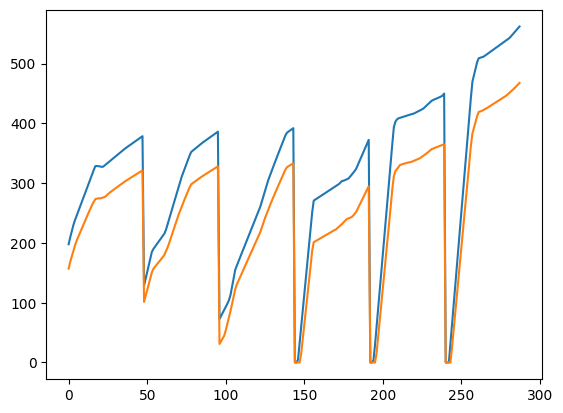

In [223]:
# plt.plot(true_in_flow[:,-3])
plt.plot(predicted_in_flow[:,-3])
plt.plot(predicted_in_flow[:,-45])

(288, 150)

In [177]:
abs(np.array(torch.tensor(np.array(ori_y)[-48:]).permute(1,0,2)[station_mask][:,:,0].permute(1,0))-predicted_in_flow).mean()

ValueError: operands could not be broadcast together with shapes (48,150) (288,150) 

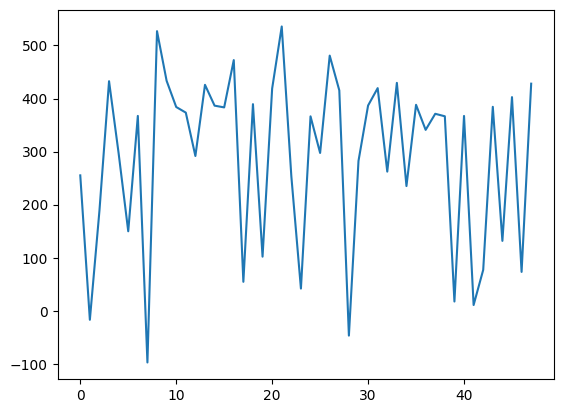

In [180]:
plt.plot(predicted_in_flow[:48,-0])
# plt.plot(predicted_in_flow[:,-1])
# plt.plot(predicted_in_flow[:,-2])
# plt.plot(predicted_in_flow[:,-3])